In [ ]:
!pip install ranx

In [ ]:
!wget -O trec-pm.tar.xz https://th-koeln.sciebo.de/s/JTTV4fxFmuCGMeY/download
!tar -xf trec-pm.tar.xz

In [ ]:
!wget -O bibliometric.tar.xz https://th-koeln.sciebo.de/s/BRolGxMzrCipoTT/download
!tar -xf bibliometric.tar.xz

In [1]:
DIR_IN = 'trec-pm/trec-pm-2017-abstracts' 
DIR_RUN = 'runs/trec-pm-2017-abstracts'    
PATH_QRELS = "trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt"
DIR_CSV = 'experimental_results/trec-pm-2017-abstracts/'
YEAR = 2017

# DIR_IN = 'trec-pm/trec-pm-2018-abstracts' 
# DIR_RUN = 'runs/trec-pm-2018-abstracts'    
# PATH_QRELS = "trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt"
# DIR_CSV = 'experimental_results/trec-pm-2018-abstracts/'
# YEAR = 2018

# DIR_IN = 'trec-pm/trec-pm-2019-abstracts' 
# DIR_RUN = 'runs/trec-pm-2019-abstracts'    
# PATH_QRELS = "trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt"
# DIR_CSV = 'experimental_results/trec-pm-2019-abstracts/'
# YEAR = 2019

In [4]:
import os
import gzip

def extract_runs(dir_in, dir_out):

    os.makedirs(dir_out, exist_ok=True)

    for root, dirs, files in os.walk(dir_in):
        for file in files:
            if file.endswith(".gz"):
                run_name = file.split('.')[1]
                with gzip.open(os.path.join(root, file), 'rb') as f_in:
                    file_content = f_in.read()
                    file_out = dir_out + '/' + run_name
                    with open(file_out, 'wb') as f_out:
                        f_out.write(file_content) 
                        if YEAR == 2019:
                            !cat $file_out | cut -d" " -f1 > tmp; mv tmp $file_out
                            
extract_runs(DIR_IN, DIR_RUN)

In [5]:
from ranx import Qrels, Run, evaluate, compare, fuse
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
sns.set_style('darkgrid')


from random import randint

def get_run(category, year=2017):
    
    run_names = {'TC': 'Citations (C)',
                 'ATTENTION_SCORE': 'Altmetrics (A)',
                 'RL': 'Research level (R)',
                 'IF': 'Impact factor (I)',
                 'PY': 'Publication year (P)',
                 'random': 'Random'}
    
    
    df = pd.read_csv('STI_Ergebnisse_final.txt', sep='\t')
    _run = Run(name=run_names[category])
    
    if category == 'random':
        _df = df[df['TOPIC'].str.contains(str(year), regex=False)]
        for row in _df.iterrows():
            topic = row[1]['TOPIC'].split('-')[1]
            pubmed_id = row[1]['PUBMED_ID']
            _run.add_score(str(topic), str(pubmed_id), randint(1,10000))
            
        return _run
    
    _df = df[df[category].notna()]
    _df = _df[_df['TOPIC'].str.contains(str(year), regex=False)]
    _df = _df[['TOPIC','PUBMED_ID', category]]
    
    if category in ['IF', 'RL']:
        _df[category] = _df[category].str.replace(',','.').astype(float)

    for row in _df.iterrows():
        topic = row[1]['TOPIC'].split('-')[1]
        pubmed_id = row[1]['PUBMED_ID']
        cnt = row[1][category]

        if cnt > 0:
            _run.add_score(str(topic), str(pubmed_id), float(cnt))
    
    return _run

In [ ]:
qrels = Qrels.from_file(PATH_QRELS, kind="trec")

run_cite = get_run('TC', year=YEAR) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score
run_py = get_run('PY', year=YEAR) 
run_rl = get_run('RL', year=YEAR) 
run_if = get_run('IF', year=YEAR) 
run_random = get_run('random', year=YEAR) 

In [216]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if, run_random],
    metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
    rounding_digits=4,
    max_p=0.05 / 6 # bonferroni correction    
)

print(report)
# print(report.to_latex())

#    Model                 NDCG       MAP        P@10     BPref       MRR
---  --------------------  ---------  ---------  -------  -------  ------
a    Citations (C)         0.4992ᵇᵈᵉ  0.1812ᵇᵉᶠ  0.2700ᵈ  0.1577ᶠ  0.3924
b    Altmetrics (A)        0.3163     0.1020     0.2400ᵈ  0.1434   0.382
c    Publication year (P)  0.5069ᵇᵈᵉ  0.1733ᵇᵉ   0.2033   0.1541ᶠ  0.3739
d    Research level (R)    0.4666ᵇᵉ   0.1546ᵇ    0.1200   0.1307   0.2461
e    Impact factor (I)     0.4162ᵇ    0.1399ᵇ    0.2500ᵈ  0.1444ᶠ  0.3815
f    Random                0.5195ᵇᵈᵉ  0.1596ᵇᵉ   0.1733   0.1171   0.4118


In [217]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if, run_random],
    metrics=["rbp.95", "rbp.9", "rbp.85", "rbp.8", "rbp.75"],
    rounding_digits=4,
    max_p=0.05 / 6 # bonferroni correction   
)

print(report)
# print(report.to_latex())

#    Model                 RBP.95    RBP.9    RBP.85      RBP.8    RBP.75
---  --------------------  --------  -------  --------  -------  --------
a    Citations (C)         0.2507ᵈᶠ  0.2595ᵈ  0.2611     0.2603    0.2593
b    Altmetrics (A)        0.2369ᵈᶠ  0.2388ᵈ  0.2367ᵈ    0.2331    0.2291
c    Publication year (P)  0.2144ᵈ   0.2128   0.2113     0.2114    0.213
d    Research level (R)    0.1542    0.1410   0.1336     0.1292    0.1265
e    Impact factor (I)     0.2272    0.2355   0.2389     0.2397    0.239
f    Random                0.1757    0.1821   0.1883     0.1948    0.2016


In [368]:
report = compare(
    qrels=qrels,
    runs=[run_cite, run_alt, run_py, run_rl, run_if, run_random],
    metrics=["ndcg@1", "ndcg@5", "ndcg@10", "ndcg@100", "ndcg@1000"],
    rounding_digits=4,
    max_p=0.05 / 6 # bonferroni correction  
)

print(report)
# print(report.to_latex())

#    Model                   NDCG@1  NDCG@5    NDCG@10    NDCG@100    NDCG@1000
---  --------------------  --------  --------  ---------  ----------  -----------
a    Citations (C)           0.1333  0.1759    0.1969     0.2225ᵈᶠ    0.4992ᵇᵈᵉ
b    Altmetrics (A)          0.1833  0.1978ᵈ   0.1935ᵈ    0.2317ᵈᶠ    0.3163
c    Publication year (P)    0.2333  0.1811    0.1745     0.2224ᵈᶠ    0.5069ᵇᵈᵉ
d    Research level (R)      0.05    0.0845    0.0839     0.1612      0.4666ᵇᵉ
e    Impact factor (I)       0.1833  0.1811    0.1864ᵈ    0.2076ᶠ     0.4162ᵇ
f    Random                  0.1667  0.1392    0.1330     0.1623      0.5195ᵇᵈᵉ


In [219]:
fuse_method = 'rrf'

fused_runs = []

run_dict = {'C': run_cite,
            'A': run_alt,
            'P': run_py,
            'R': run_rl,
            'I': run_if}

# https://stackoverflow.com/questions/464864/how-to-get-all-possible-combinations-of-a-list-s-elements
import itertools

# run_codes = ['a', 'b', 'c', 'd', 'e']
run_codes = list(run_dict.keys())

for L in range(len(run_codes) + 1):
    for subset in itertools.combinations(run_codes, L):
        if len(subset) > 1:
            
            run_name = ''.join(list(subset))
            comb = [run_dict.get(code) for code in subset]
            run_fuse = fuse(runs=comb, method=fuse_method)
            run_fuse.name = run_name
            fused_runs.append(run_fuse)
                 
# runs = [run_cite, run_alt, run_rl, run_if, run_py, run_random] + fused_runs
  
report = compare(
    qrels=qrels,
    runs=fused_runs,
    metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
    rounding_digits=4,
    max_p=0.01 / 26
)

print(report)
# print(report.to_latex())

#    Model    NDCG               MAP              P@10  BPref        MRR
---  -------  -----------------  -------------  ------  --------  ------
a    CA       0.5256ᵈᵍʲᵖ         0.1917ᵍʲ       0.27    0.1674    0.5069
b    CP       0.5217ᵍʲ           0.1919ʲᵗ       0.2733  0.1695ʲ   0.5179
c    CR       0.4967ʲ            0.1721         0.2067  0.1459    0.4162
d    CI       0.5034ʲ            0.1784         0.2767  0.1538    0.4278
e    AP       0.5299ᵍʰʲᵗ         0.1880         0.2533  0.1698    0.4874
f    AR       0.5061ʲ            0.1743ʲ        0.2267  0.1513    0.402
g    AI       0.4872             0.1712         0.2967  0.1589    0.4977
h    PR       0.4978ʲ            0.1677         0.22    0.1425    0.3201
i    PI       0.5157ᵍʲ           0.1795         0.2767  0.1563    0.5062
j    RI       0.4755             0.1587         0.2     0.1350    0.4064
k    CAP      0.5374ᶜᵈᶠᵍʰʲᵒᵖˢᵗˣ  0.1977ᶠᵍʲˢᵗ    0.2867  0.1749ᶠʲ  0.5511
l    CAR      0.5189ᶜᵍʲᵖˣ        0.1848ʲᵖ       0.25

In [456]:
fuse_method = "rrf"

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_rrf = fuse(runs=[run, run_cite, run_alt, run_py], method=fuse_method)

        report = compare(
            qrels=qrels,
            runs=[run, run_rrf],
            # metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
            metrics=["ndcg", "map", "precision@10", "bpref", "mrr", 
                     "ndcg@1", "ndcg@5", "ndcg@10", "ndcg@50",
                     "ndcg@100", "ndcg@200", "ndcg@500", "ndcg@1000", 
                     "rbp.99", "rbp.985", "rbp.98", "rbp.975", "rbp.97", 
                     "rbp.965", "rbp.96", "rbp.955", "rbp.95",
                     "rbp.945","rbp.94","rbp.935","rbp.93","rbp.925",
                     "rbp.92","rbp.915","rbp.91", "rbp.905", "rbp.9"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_method).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_method)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.csv'
df.to_csv(file_out)

# TREC PM 2017 - Abstracts

In [79]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')

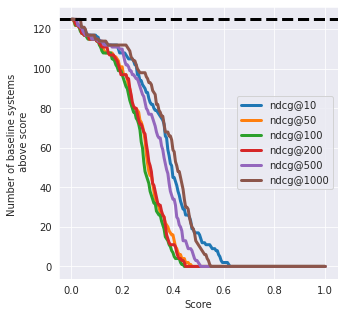

In [80]:
df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (base)'] > thresh)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(figsize=(5,5), linewidth=3, xlabel='Score', ylabel='Number of baseline systems \n above score')
plt.axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

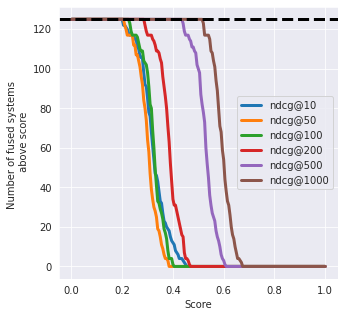

In [9]:
df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (fuse)'] > thresh)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(figsize=(5,5), linewidth=3, xlabel='Score', ylabel='Number of fused systems \n above score')
plt.axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

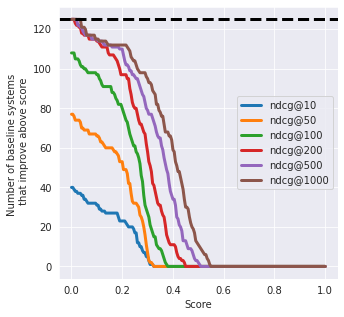

In [8]:
df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (base)'] > thresh) & (df[measure +' (diff)'] > 0)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(figsize=(5,5), linewidth=3, xlabel='Score', ylabel='Number of baseline systems \n that improve above score')

plt.axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

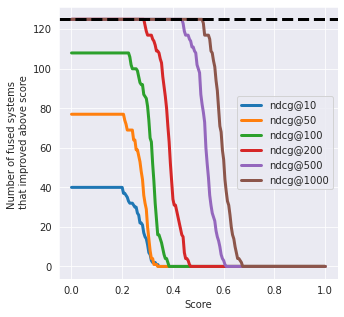

In [10]:
df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (fuse)'] > thresh) & (df[measure +' (diff)'] > 0)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(figsize=(5,5), linewidth=3, xlabel='Score', ylabel='Number of fused systems \n that improved above score')

plt.axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

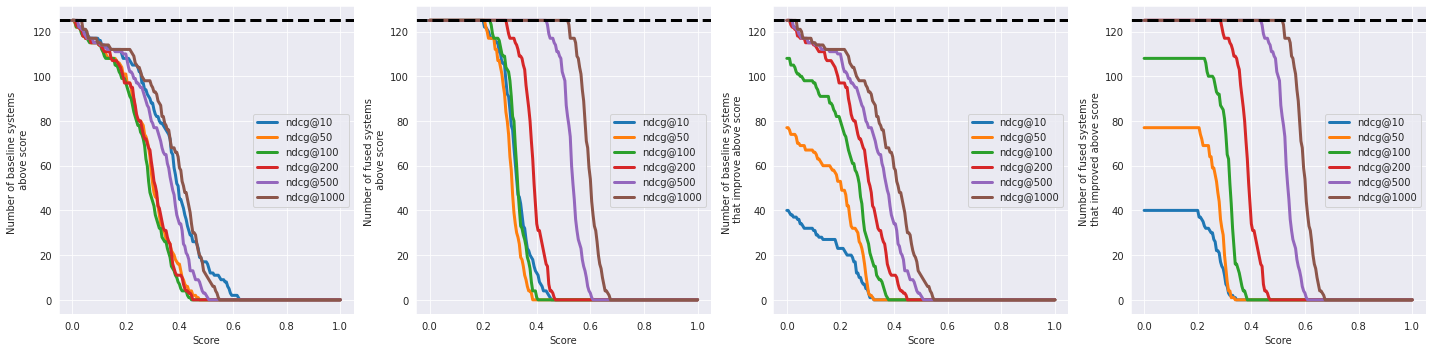

In [93]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20,5))

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (base)'] > thresh)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of baseline systems \n above score', ax=axes[0])
axes[0].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (fuse)'] > thresh)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of fused systems \n above score', ax=axes[1])
axes[1].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (base)'] > thresh) & (df[measure +' (diff)'] > 0)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of baseline systems \n that improve above score', ax=axes[2])
axes[2].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

df_data = {}
for measure in [ 'ndcg@10', 'ndcg@50', 'ndcg@100', 'ndcg@200', 'ndcg@500', 'ndcg@1000']:
    _data = {}
    for thresh in [round(0.005*i, 3) for i in range(0,201)]:
        _data[thresh] = len(df[(df[measure +' (fuse)'] > thresh) & (df[measure +' (diff)'] > 0)])
    df_data[measure] = _data
_df = pd.DataFrame.from_dict(df_data)
_df.plot(linewidth=3, xlabel='Score', ylabel='Number of fused systems \n that improved above score', ax=axes[3])
axes[3].axhline(y = len(df), color='black',linestyle = '--', linewidth=3)

plt.tight_layout()
plt.savefig('figures/trec-pm-2017-abstracts/ndcg.rrf.pdf',bbox_inches='tight')

## RBP experiments - the more patient the user, the higher the benefit.

In [ ]:
fuse_method = "rrf"

_metrics = ['rbp.' + str(round(0.8 + 0.005*i, 3)).replace('0.', '') for i in range(0,40)]

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_rrf = fuse(runs=[run, run_cite, run_alt, run_py], method=fuse_method)

        report = compare(
            qrels=qrels,
            runs=[run, run_rrf],

            metrics=_metrics,
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_method).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_method)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.rbp.csv'
df.to_csv(file_out)

/tmp/ipykernel_732495/3420819843.py:68: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  run_cite = get_run('TC', year=YEAR) # get run based on citations
/tmp/ipykernel_732495/3420819843.py:69: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score
/tmp/ipykernel_732495/3420819843.py:70: DtypeWarning: Columns (2,5,7,8,9,10,12,13,14,15,16,18) have mixed types.Specify dtype option on import or set low_memory=False.
  run_py = get_run('PY', year=YEAR)


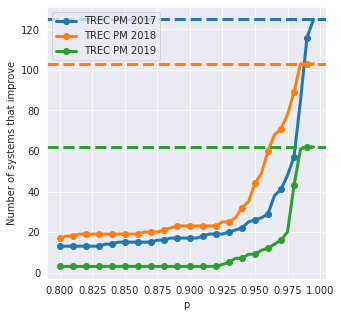

In [95]:
df_2017 = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.rbp.csv')
df_2018 = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.rbp.csv')
df_2019 = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.rbp.csv')

_data_2017 = {}
_data_2018 = {}
_data_2019 = {}
_range = [round(0.8 + 0.005*i, 3) for i in range(0,40)]
for p in _range:
    _data_2017[p] = len(df_2017[df_2017['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
    _data_2018[p] = len(df_2018[df_2018['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
    _data_2019[p] = len(df_2019[df_2019['rbp.' + str(p).replace('0.', '') +' (diff)'] > 0])
pd.DataFrame.from_dict({'TREC PM 2017': _data_2017, 'TREC PM 2018': _data_2018, 'TREC PM 2019': _data_2019}).plot(xlabel='p', ylabel='Number of systems that improve', figsize=(5,5), marker='o', linewidth=3, markevery=2)
plt.axhline(y = len(df_2017), color='tab:blue',linestyle = '--', linewidth=3)
plt.axhline(y = len(df_2018), color='tab:orange',linestyle = '--', linewidth=3)
plt.axhline(y = len(df_2019), color='tab:green',linestyle = '--', linewidth=3)

plt.savefig('figures/rbp.rrf.pdf', bbox_inches='tight')

## AP

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')

<AxesSubplot:xlabel='run', ylabel='$\\Delta$ AP'>

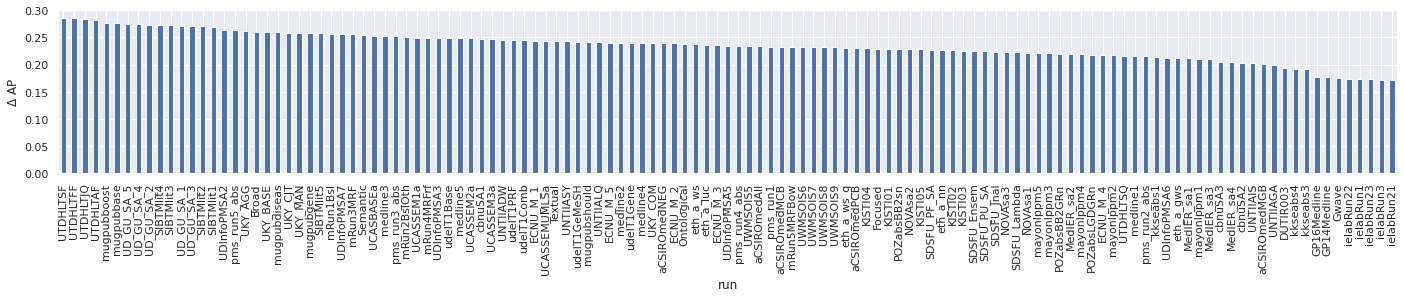

In [476]:
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', figsize=(24,3), ylabel=r'$\Delta$ AP', legend=False)

## nDCG

<AxesSubplot:xlabel='run', ylabel='$\\Delta$ nDCG'>

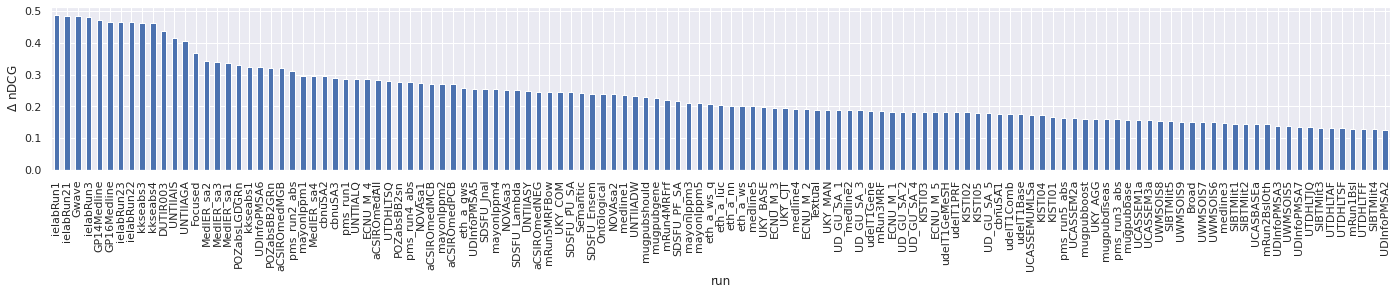

In [478]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3), ylabel=r'$\Delta$ nDCG', legend=False)

## P@10

<AxesSubplot:xlabel='run', ylabel='$\\Delta$ P@10'>

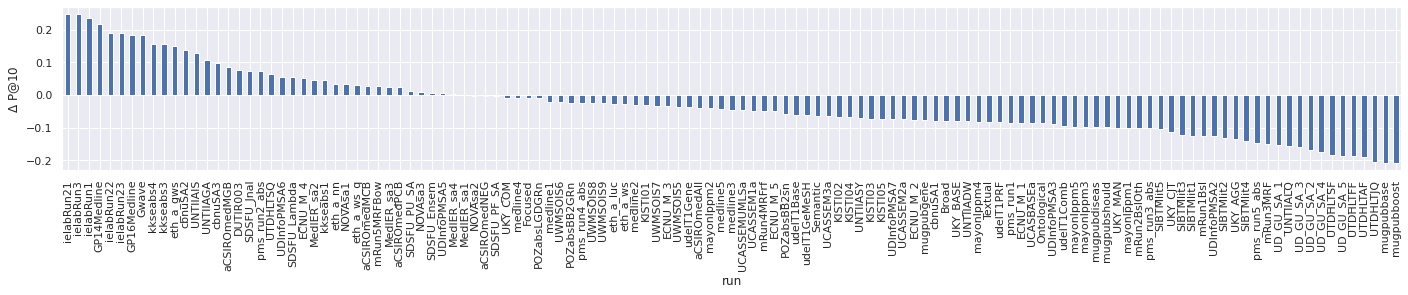

In [477]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3), ylabel=r'$\Delta$ P@10', legend=False)

## Bpref

<AxesSubplot:xlabel='run', ylabel='$\\Delta$ Bpref'>

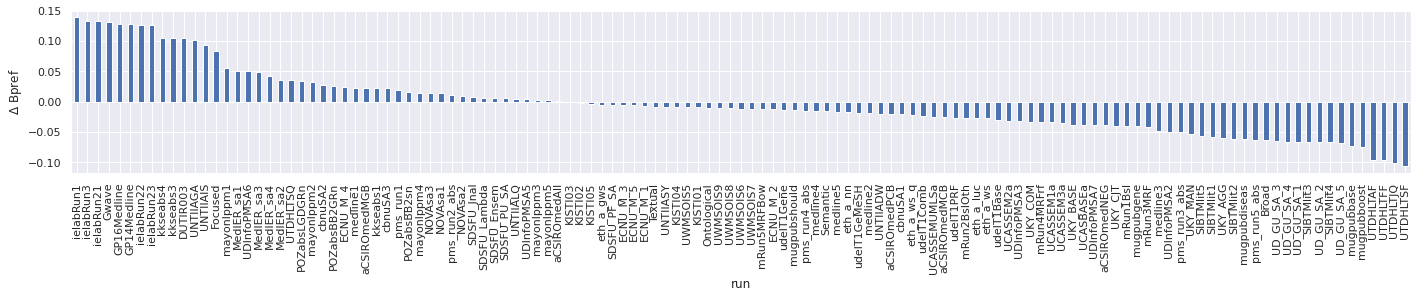

In [479]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3), ylabel=r'$\Delta$ Bpref', legend=False)

## MRR

<AxesSubplot:xlabel='run', ylabel='$\\Delta$ MRR'>

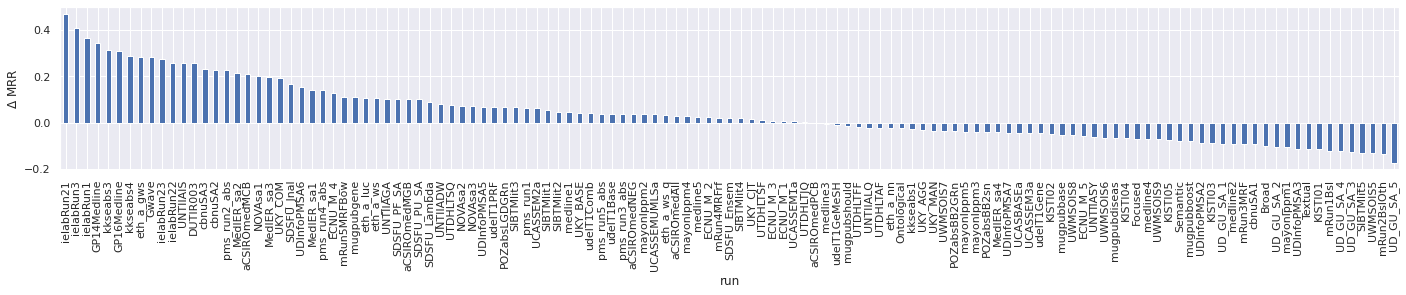

In [481]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3), ylabel=r'$\Delta$ MRR', legend=False)

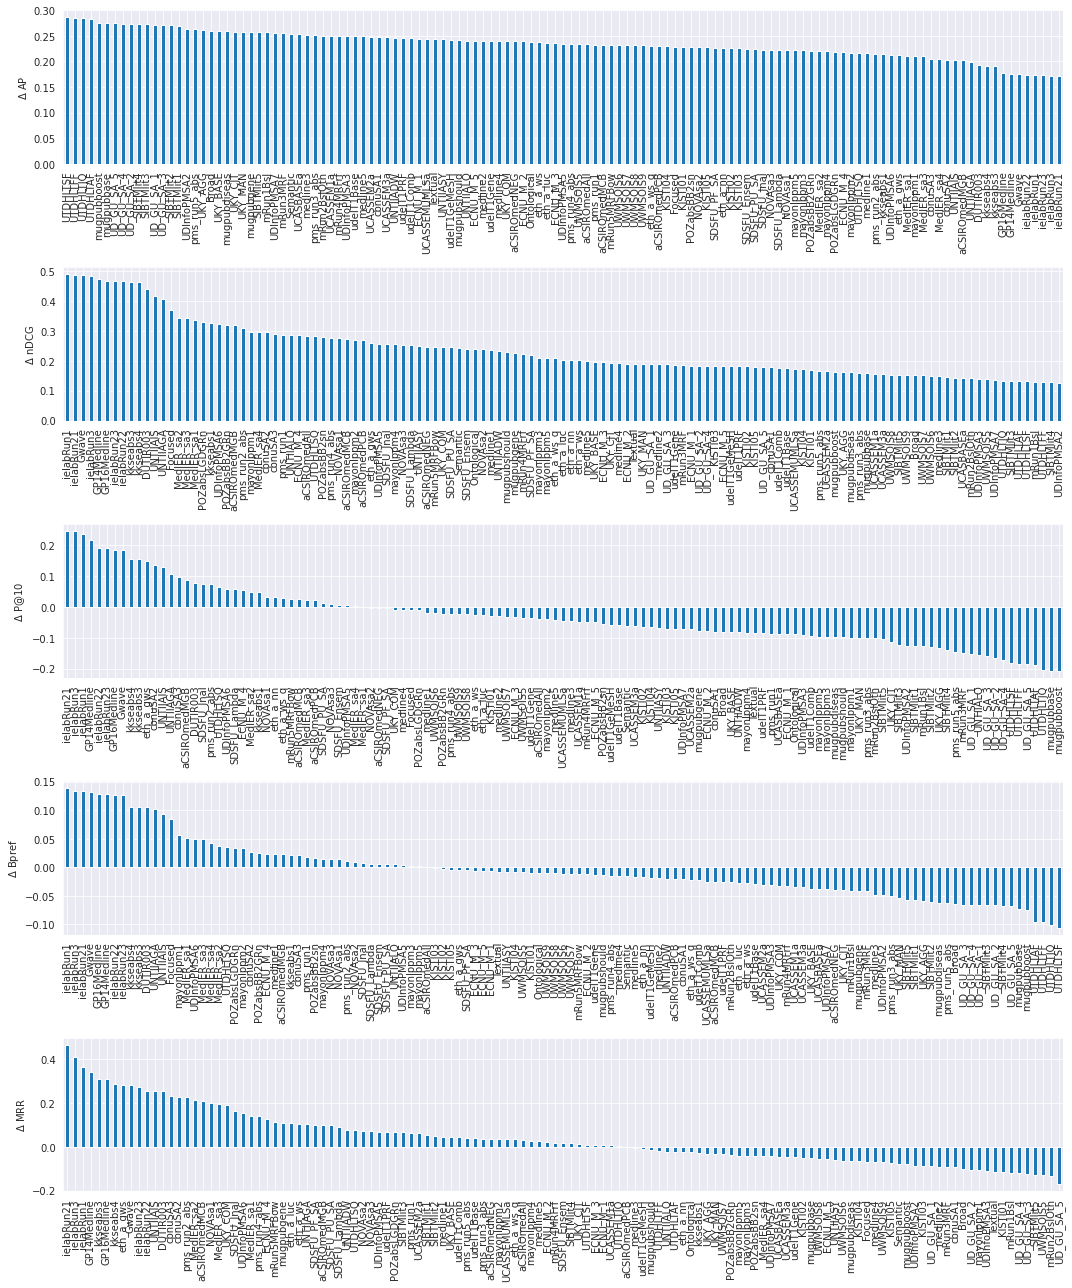

In [94]:
df = pd.read_csv('experimental_results/trec-pm-2017-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,18))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[0])
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[1])
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2])
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3])
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', ylabel=r'$\Delta$ MRR', xlabel='', legend=False, ax=axes[4])
plt.tight_layout()
plt.savefig('figures/trec-pm-2017-abstracts/delta.rrf.pdf',bbox_inches='tight')

# TREC PM 2018 - Abstracts

## AP

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.csv')

<AxesSubplot:xlabel='run'>

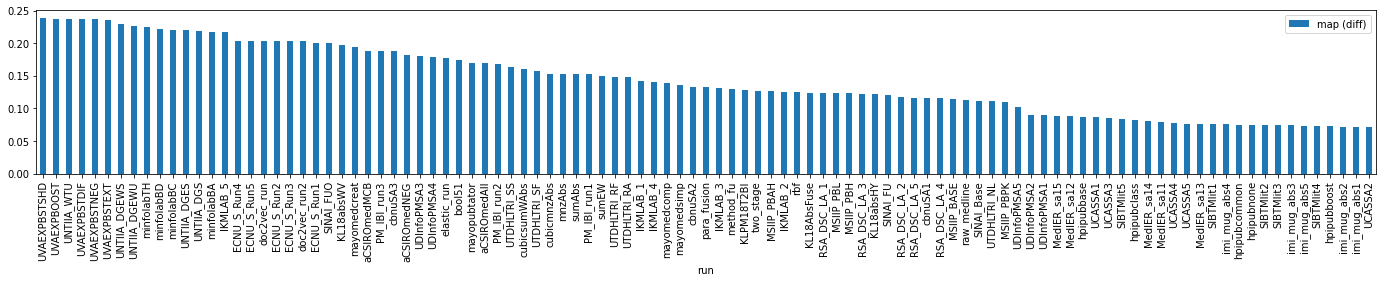

In [ ]:
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

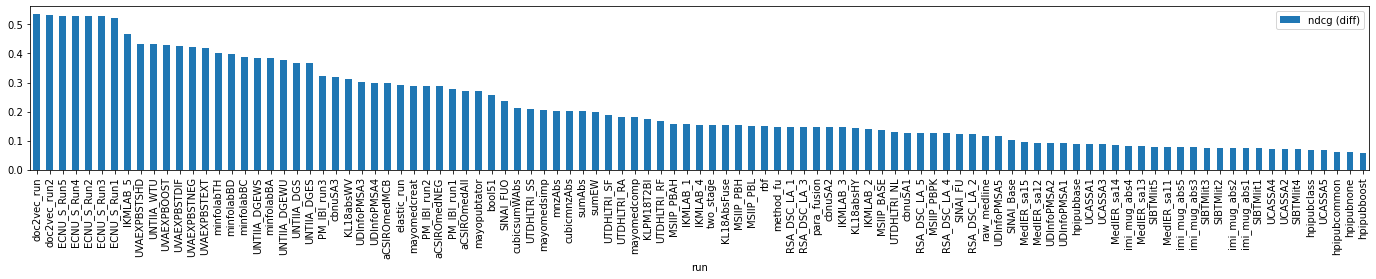

In [ ]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

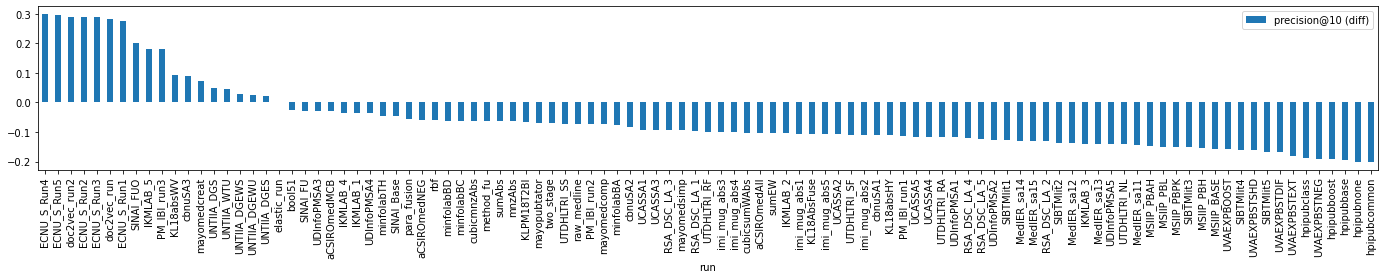

In [ ]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

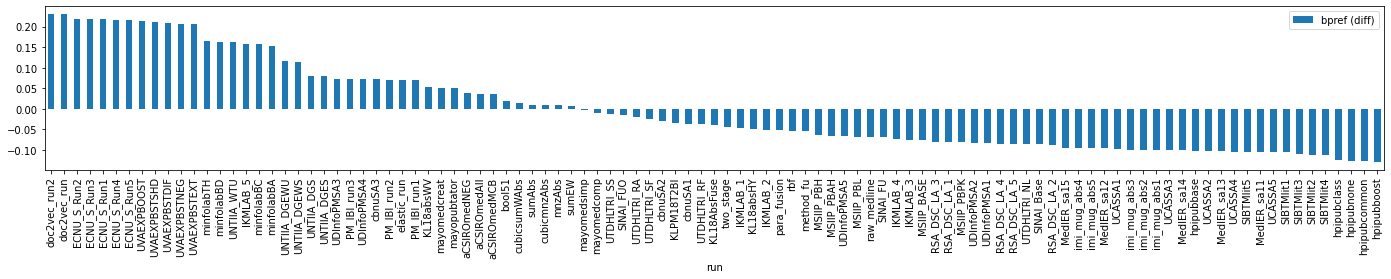

In [ ]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

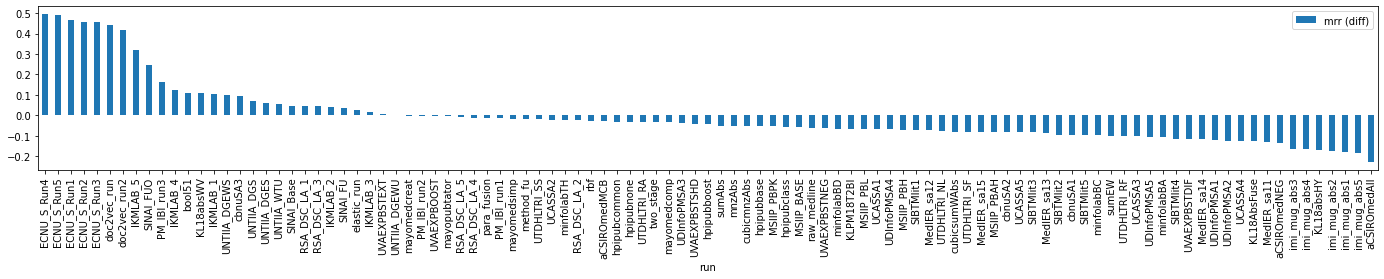

In [ ]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))

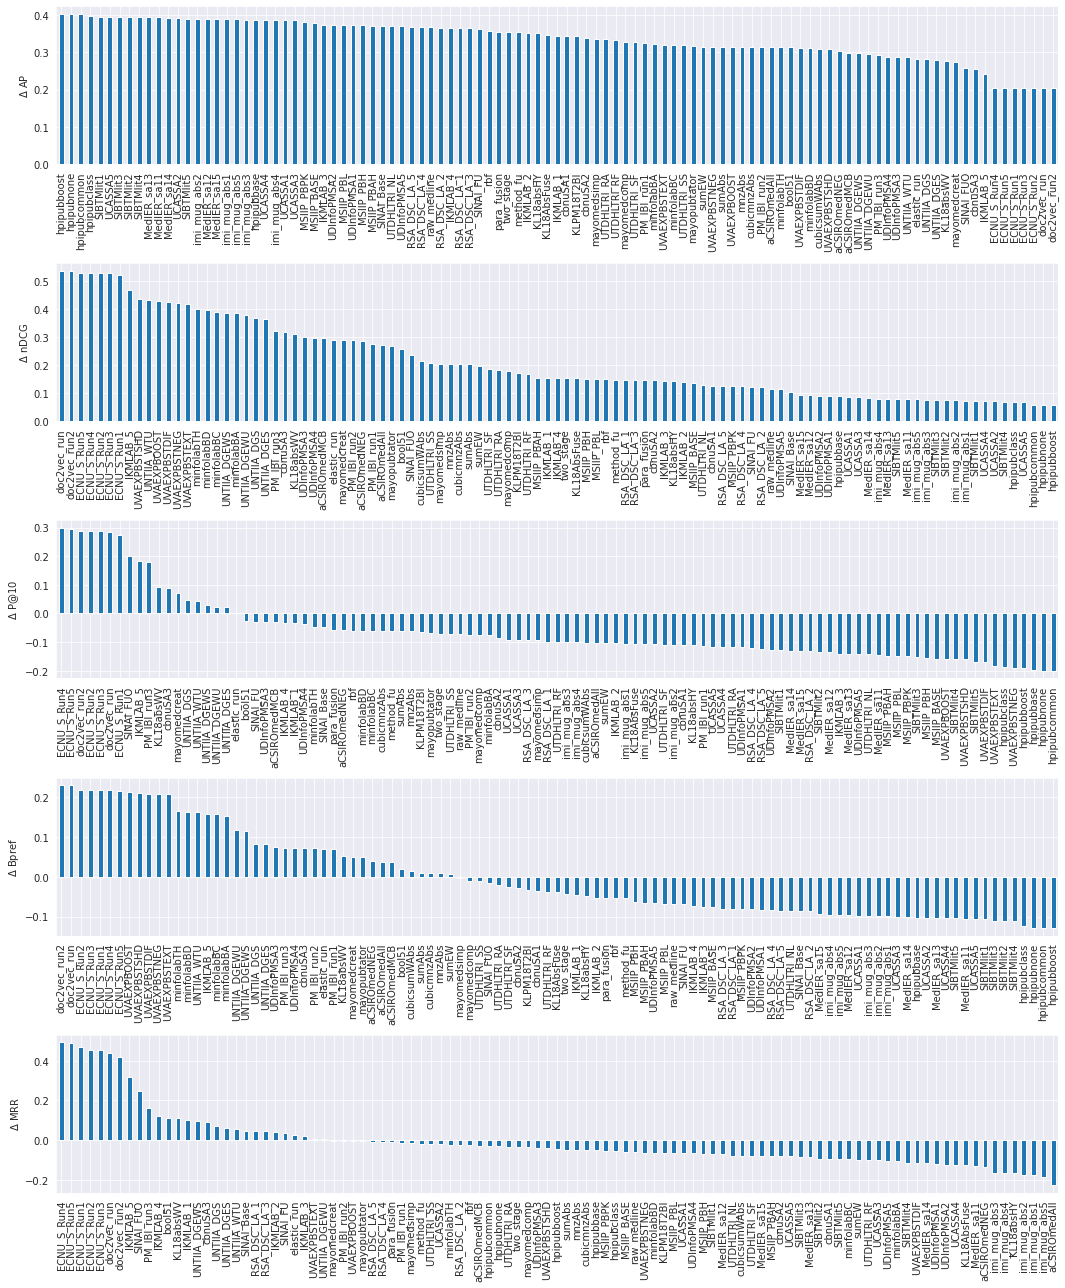

In [97]:
df = pd.read_csv('experimental_results/trec-pm-2018-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,18))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[0])
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[1])
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2])
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3])
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', ylabel=r'$\Delta$ MRR', xlabel='', legend=False, ax=axes[4])
plt.tight_layout()
plt.savefig('figures/trec-pm-2018-abstracts/delta.rrf.pdf',bbox_inches='tight')

# TREC PM 2019 - Abstracts

## AP

<AxesSubplot:xlabel='run'>

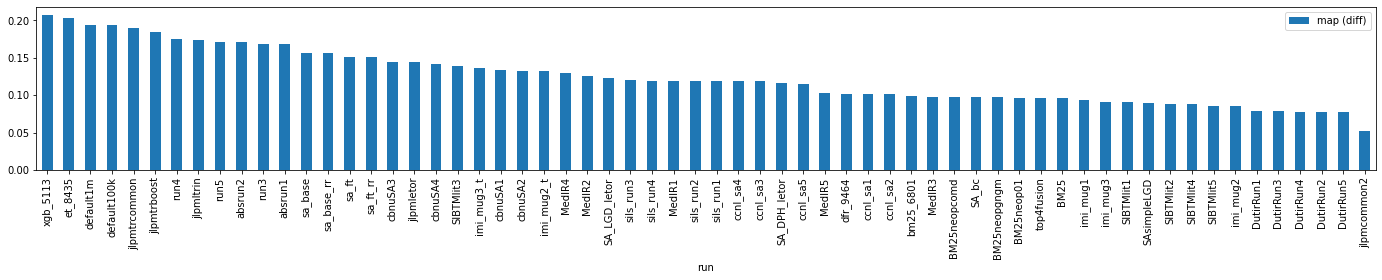

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.csv')
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

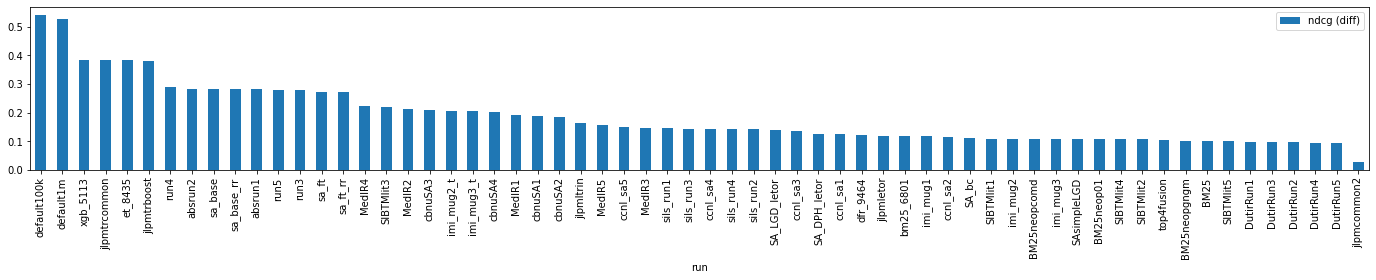

In [ ]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

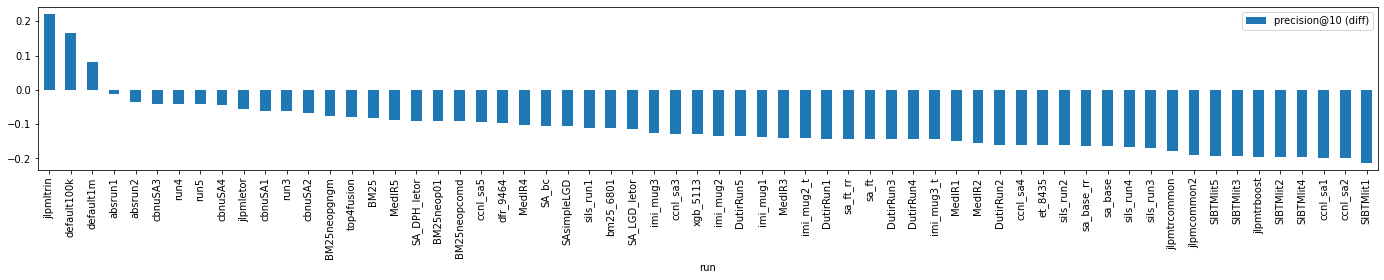

In [ ]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

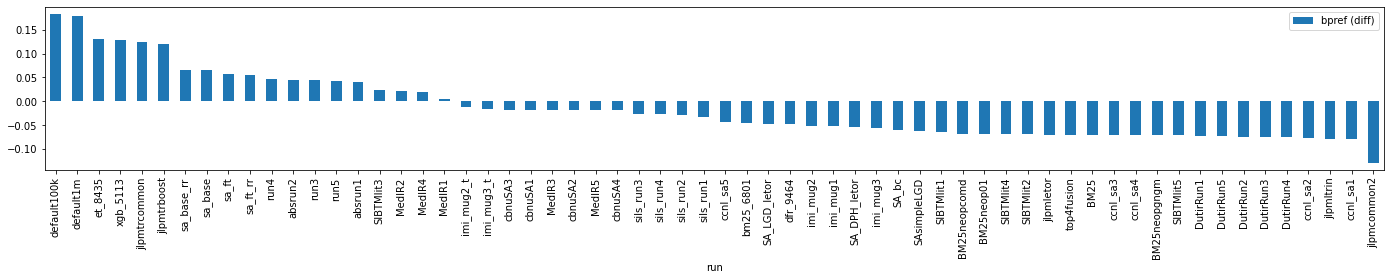

In [ ]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

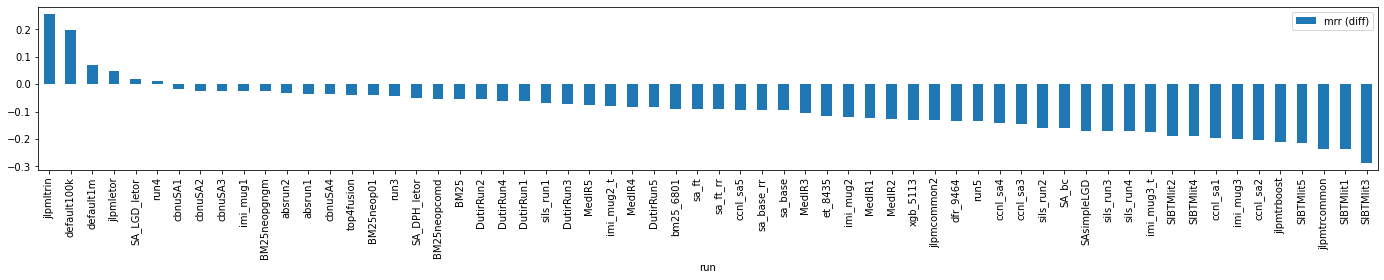

In [ ]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3))

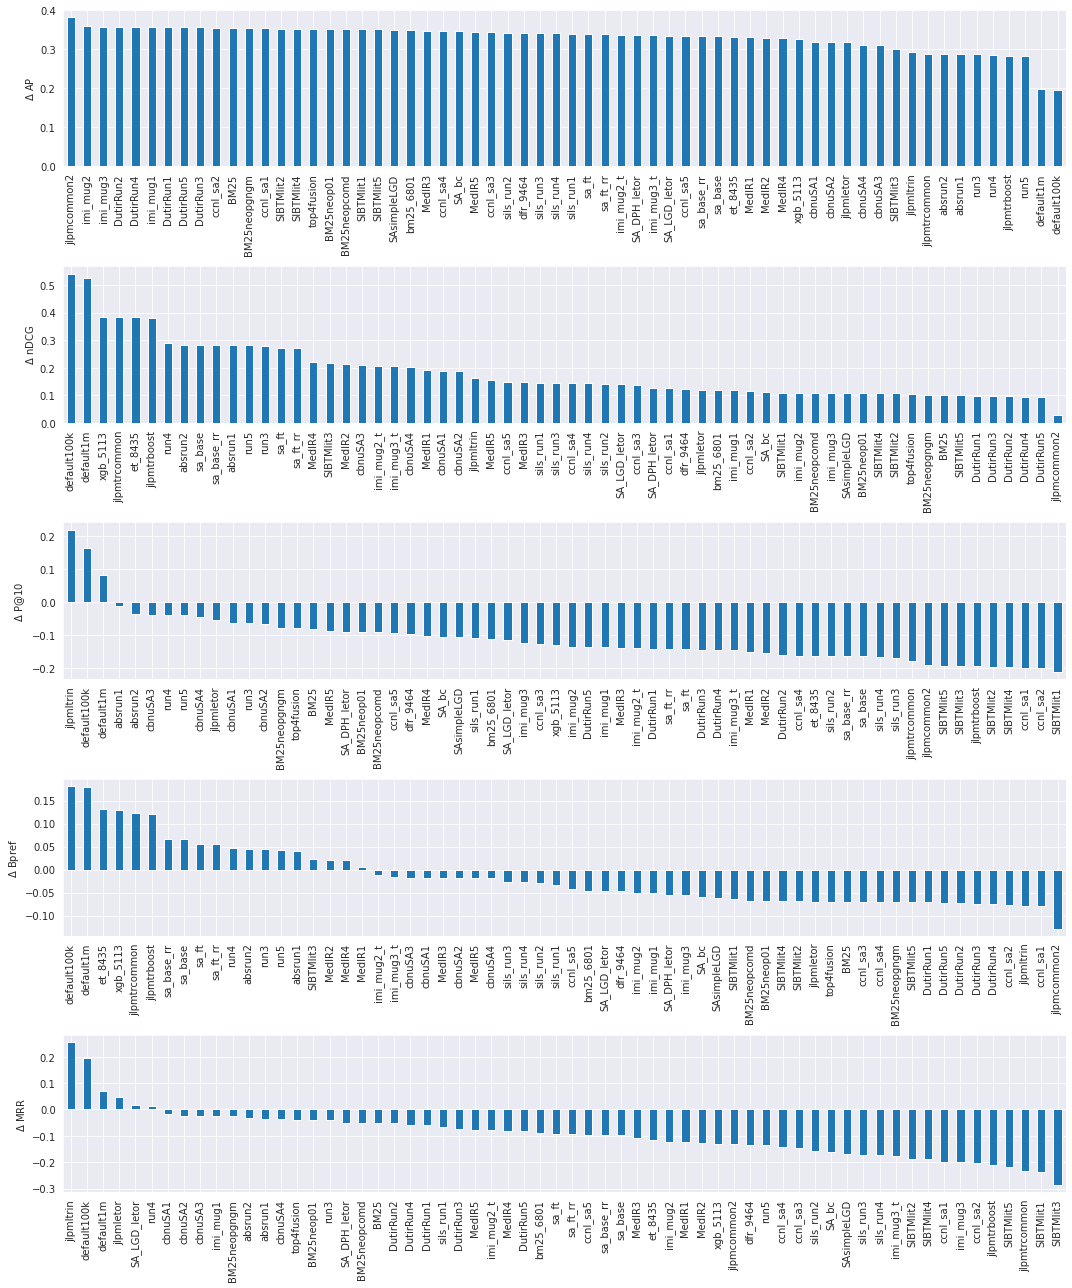

In [98]:
df = pd.read_csv('experimental_results/trec-pm-2019-abstracts/rrf.csv')
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15,18))
df.sort_values(by=['map (fuse)'], ascending=False).plot.bar(x='run', y='map (fuse)', ylabel=r'$\Delta$ AP', xlabel='', legend=False, ax=axes[0])
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', ylabel=r'$\Delta$ nDCG', xlabel='', legend=False, ax=axes[1])
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', ylabel=r'$\Delta$ P@10', xlabel='', legend=False, ax=axes[2])
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', ylabel=r'$\Delta$ Bpref', xlabel='', legend=False, ax=axes[3])
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', ylabel=r'$\Delta$ MRR', xlabel='', legend=False, ax=axes[4])
plt.tight_layout()
plt.savefig('figures/trec-pm-2019-abstracts/delta.rrf.pdf',bbox_inches='tight')

# Optimized Fusion Methods

see also: https://amenra.github.io/ranx/fusion/

In [ ]:
from ranx import fuse, optimize_fusion, Qrels, Run
import os, random
import matplotlib.pyplot as plt
import pandas as pd

# fuse_method = "wsum"
# fuse_dict_key = "weighted_sum"

# fuse_method = "gmnz"
# fuse_dict_key = "comb_gmnz"

# fuse_method = "rbc"
# fuse_dict_key = fuse_method

# fuse_method = "probfuse"
# fuse_dict_key = fuse_method

# fuse_method = "slidefuse"
# fuse_dict_key = fuse_method

# fuse_method = "bayesfuse"
# fuse_dict_key = fuse_method

# fuse_method = "logn_isr"
# fuse_dict_key = fuse_method

# fuse_method = "posfuse"
# fuse_dict_key = fuse_method

# fuse_method = "mapfuse"
# fuse_dict_key = fuse_method

fuse_method = "segfuse"
fuse_dict_key = fuse_method

if YEAR == 2017:
    samples = 5
    dir_train = 'runs/trec-pm-2018-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2018-abstracts/qrels-treceval-abstracts-2018-v2.txt', kind="trec")
    
if YEAR == 2018:
    samples = 5
    dir_train = 'runs/trec-pm-2019-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2019-abstracts/qrels-treceval-abstracts.2019.txt', kind="trec")

if YEAR == 2019:
    samples = 5
    dir_train = 'runs/trec-pm-2017-abstracts/'
    train_runs = [Run.from_file(dir_train + random.choice(os.listdir(dir_train)), kind='trec') for i in range(0,samples)]
    train_qrels = Qrels.from_file('trec-pm/trec-pm-2017-abstracts/qrels-final-abstracts.txt', kind="trec")

best_params = optimize_fusion(
    qrels=train_qrels,
    runs=train_runs,
    norm="min-max",
    method=fuse_method,
    metric="ndcg@100"
)

run_cite = get_run('TC', year=YEAR) # get run based on citations
run_alt = get_run('ATTENTION_SCORE', year=YEAR) # get run based on attention score
qrels = Qrels.from_file(PATH_QRELS, kind="trec")

df_data = []

for root, dirs, files in os.walk(DIR_RUN):
    for file in files:
        run = Run.from_file(os.path.join(root, file), kind="trec")
        
        run_fuse = fuse(
            runs=[run, run_cite, run_alt],  
            norm="min-max",       
            method=fuse_method,        
            params=best_params,
        )

        report = compare(
            qrels=qrels,
            runs=[run, run_fuse],
            metrics=["ndcg", "map", "precision@10", "bpref", "mrr"],
            max_p=0.05  
        )

        report_dict = report.to_dict()
        metrics = report_dict.get('metrics')
        base_name = report_dict.get('model_names')[0]
        base_scores = report_dict.get(base_name).get('scores')
        fuse_scores = report_dict.get(fuse_dict_key).get('scores')
        base_pval = report_dict.get(base_name).get('comparisons').get(fuse_dict_key)

        _eval = {'run': base_name}

        for metric in metrics:
            _eval[metric + ' (base)'] = base_scores.get(metric)
            _eval[metric + ' (fuse)'] = fuse_scores.get(metric)
            _eval[metric + ' (diff)'] = fuse_scores.get(metric) - base_scores.get(metric)
            _eval[metric + ' (pval)'] = base_pval.get(metric)
            
        df_data.append(_eval)
        
df = pd.DataFrame(df_data)

os.makedirs(DIR_CSV, exist_ok=True)
file_out = DIR_CSV + fuse_method + '.csv'
df.to_csv(file_out)

## AP

<AxesSubplot:xlabel='run'>

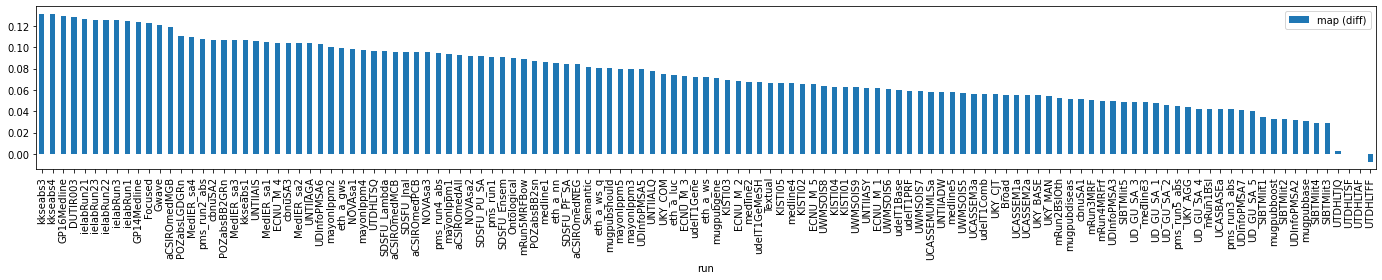

In [ ]:
df = pd.read_csv('experimental_results/trec-pm-' + str(YEAR) + '-abstracts/' + fuse_method + '.csv')
df.sort_values(by=['map (diff)'], ascending=False).plot.bar(x='run', y='map (diff)', figsize=(24,3))

## nDCG

<AxesSubplot:xlabel='run'>

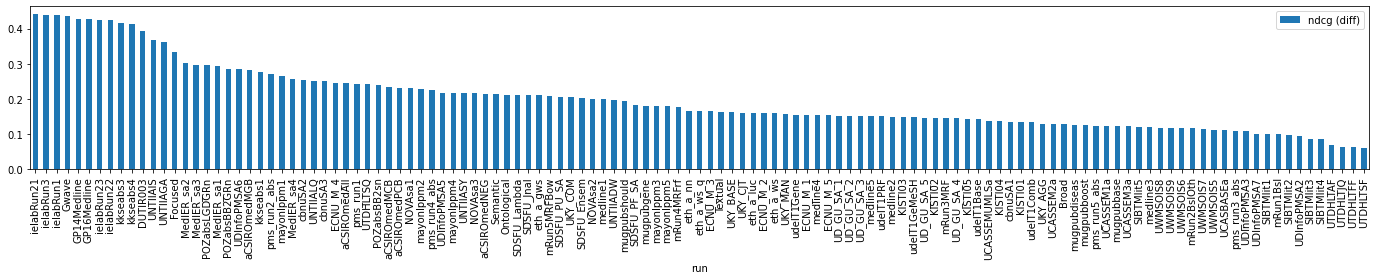

In [ ]:
df.sort_values(by=['ndcg (diff)'], ascending=False).plot.bar(x='run', y='ndcg (diff)', figsize=(24,3))

## P@10

<AxesSubplot:xlabel='run'>

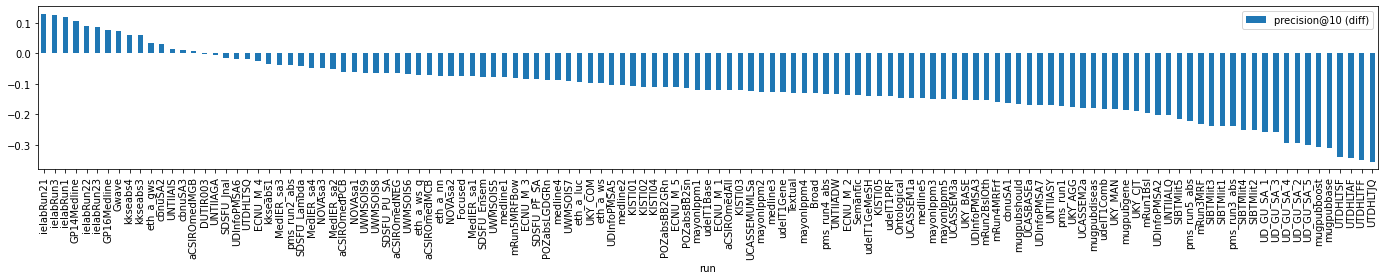

In [ ]:
df.sort_values(by=['precision@10 (diff)'], ascending=False).plot.bar(x='run', y='precision@10 (diff)', figsize=(24,3))

## Bpref

<AxesSubplot:xlabel='run'>

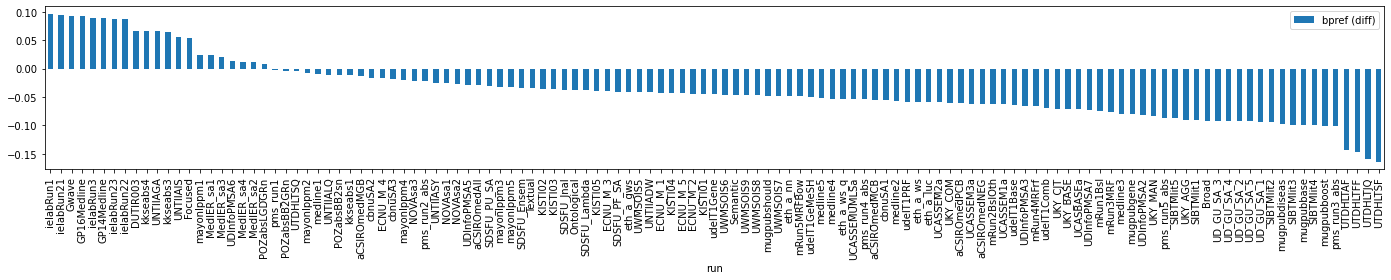

In [ ]:
df.sort_values(by=['bpref (diff)'], ascending=False).plot.bar(x='run', y='bpref (diff)', figsize=(24,3))

## MRR

<AxesSubplot:xlabel='run'>

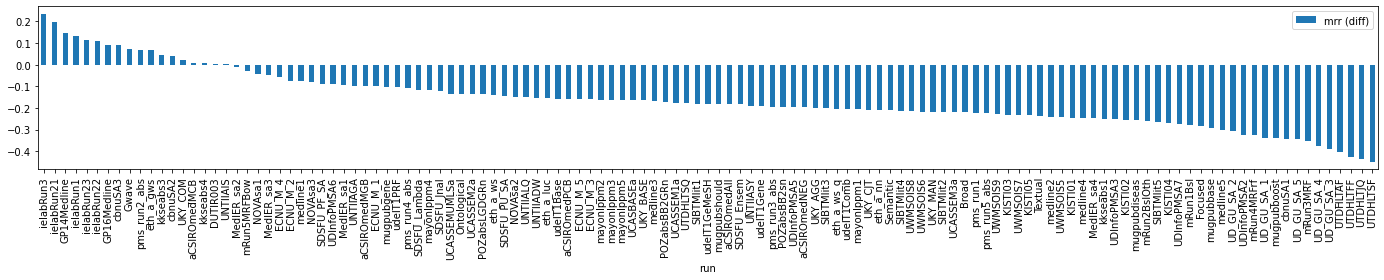

In [ ]:
df.sort_values(by=['mrr (diff)'], ascending=False).plot.bar(x='run', y='mrr (diff)', figsize=(24,3)

## General statistics about how rank fusion changes the retrieval performance

In [150]:
def general_stats(method):
    data = {}
    for year in [2017, 2018, 2019]:
        
        path = 'experimental_results/trec-pm-' + str(year) + '-abstracts/' + method + '.csv'
        df = pd.read_csv(path)
        _data = {
            'Number of systems': len(df),
            'Improvements (nDCG)': len(df[df['ndcg (diff)'] > 0]),
            'Signif. improvements (nDCG)': len(df[(df['ndcg (pval)'] < 0.05) & (df['ndcg (diff)'] > 0)]),
            'Average improvement (nDCG)': df[(df['ndcg (pval)'] < 0.05) & (df['ndcg (diff)'] > 0)]['ndcg (diff)'].mean(),
            'Overall change (nDCG)': df['ndcg (diff)'].mean(),
            'Improvements (AP)': len(df[df['map (diff)'] > 0]),
            'Signif. improvements (AP)': len(df[(df['map (pval)'] < 0.05) & (df['map (diff)'] > 0)]),
            'Average improvement (AP)': df[(df['map (pval)'] < 0.05) & (df['map (diff)'] > 0)]['map (diff)'].mean(),
            'Overall change (AP)': df['map (diff)'].mean(),
            'Improvements (P@10)': len(df[df['precision@10 (diff)'] > 0]),
            'Signif. improvements (P@10)': len(df[(df['precision@10 (pval)'] < 0.05) & (df['precision@10 (diff)'] > 0)]),
            'Average improvement (P@10)': df[(df['precision@10 (pval)'] < 0.05) & (df['precision@10 (diff)'] > 0)]['precision@10 (diff)'].mean(),
            'Overall change (P@10)': df['precision@10 (diff)'].mean(),
            'Improvements (Bpref)': len(df[df['bpref (diff)'] > 0]),
            'Signif. improvements (Bpref)': len(df[(df['bpref (pval)'] < 0.05) & (df['bpref (diff)'] > 0)]),
            'Average improvement (Bpref)': df[(df['bpref (pval)'] < 0.05) & (df['bpref (diff)'] > 0)]['bpref (diff)'].mean(),
            'Overall change (Bpref)': df['bpref (diff)'].mean()
        }
        data[year] = _data

    return pd.DataFrame.from_dict(data).reindex(_data.keys())

Reciprocal Rank Fusion (RRF)

In [151]:
general_stats('rrf')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,61.000000
Average improvement (nDCG),0.237820,0.216242,0.188202
Overall change (nDCG),0.237820,0.216242,0.185639
Improvements (AP),125.000000,103.000000,62.000000
Signif. improvements (AP),123.000000,103.000000,61.000000
Average improvement (AP),0.117309,0.143297,0.125433
Overall change (AP),0.116318,0.143297,0.124254
Improvements (P@10),37.000000,19.000000,3.000000


BayesFuse

In [152]:
general_stats('bayesfuse')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,62.000000
Average improvement (nDCG),0.152648,0.234293,0.205344
Overall change (nDCG),0.152648,0.234293,0.205344
Improvements (AP),79.000000,103.000000,62.000000
Signif. improvements (AP),39.000000,103.000000,62.000000
Average improvement (AP),0.033246,0.179819,0.167270
Overall change (AP),0.008406,0.179819,0.167270
Improvements (P@10),15.000000,40.000000,5.000000


CombGMNZ

In [153]:
general_stats('gmnz')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,62.000000
Average improvement (nDCG),0.183682,0.183205,0.179778
Overall change (nDCG),0.183682,0.183205,0.179778
Improvements (AP),125.000000,103.000000,62.000000
Signif. improvements (AP),116.000000,103.000000,62.000000
Average improvement (AP),0.044010,0.074127,0.082390
Overall change (AP),0.042220,0.074127,0.082390
Improvements (P@10),31.000000,53.000000,6.000000


LogN_ISR

In [154]:
general_stats('logn_isr')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,62.000000
Average improvement (nDCG),0.216621,0.215366,0.197849
Overall change (nDCG),0.216621,0.215366,0.197849
Improvements (AP),125.000000,103.000000,62.000000
Signif. improvements (AP),121.000000,103.000000,62.000000
Average improvement (AP),0.093838,0.150380,0.141676
Overall change (AP),0.092059,0.150380,0.141676
Improvements (P@10),16.000000,16.000000,3.000000


MAPFuse

In [155]:
general_stats('mapfuse')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,62.000000
Average improvement (nDCG),0.196789,0.198210,0.183094
Overall change (nDCG),0.196789,0.198210,0.183094
Improvements (AP),125.000000,103.000000,62.000000
Signif. improvements (AP),104.000000,103.000000,61.000000
Average improvement (AP),0.068793,0.100485,0.098757
Overall change (AP),0.062322,0.100485,0.097714
Improvements (P@10),10.000000,17.000000,3.000000


PosFuse

In [156]:
general_stats('posfuse')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),105.000000,103.000000,61.000000
Average improvement (nDCG),0.189949,0.216271,0.179109
Overall change (nDCG),0.166819,0.216271,0.176449
Improvements (AP),105.000000,103.000000,62.000000
Signif. improvements (AP),62.000000,103.000000,56.000000
Average improvement (AP),0.092933,0.137221,0.111133
Overall change (AP),0.050845,0.137221,0.104834
Improvements (P@10),15.000000,18.000000,3.000000


ProbFuse

In [157]:
general_stats('probfuse')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,62.000000
Average improvement (nDCG),0.188657,0.177987,0.171001
Overall change (nDCG),0.188657,0.177987,0.171001
Improvements (AP),125.000000,103.000000,62.000000
Signif. improvements (AP),102.000000,93.000000,54.000000
Average improvement (AP),0.062342,0.072231,0.080262
Overall change (AP),0.054423,0.067030,0.074301
Improvements (P@10),16.000000,14.000000,6.000000


RBC

In [158]:
general_stats('rbc')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,102.000000,61.000000
Average improvement (nDCG),0.195954,0.197274,0.170714
Overall change (nDCG),0.195954,0.195674,0.168113
Improvements (AP),123.000000,103.000000,61.000000
Signif. improvements (AP),93.000000,78.000000,41.000000
Average improvement (AP),0.074327,0.126012,0.101227
Overall change (AP),0.062538,0.102813,0.078975
Improvements (P@10),15.000000,17.000000,3.000000


SegFuse

In [159]:
general_stats('segfuse')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,62.000000
Average improvement (nDCG),0.199673,0.219529,0.205441
Overall change (nDCG),0.199673,0.219529,0.205441
Improvements (AP),123.000000,103.000000,62.000000
Signif. improvements (AP),103.000000,103.000000,62.000000
Average improvement (AP),0.083510,0.141584,0.133808
Overall change (AP),0.074672,0.141584,0.133808
Improvements (P@10),15.000000,22.000000,3.000000


SlideFuse

In [160]:
general_stats('slidefuse')

,2017,2018,2019
Number of systems,125.000000,103.000000,62.000000
Improvements (nDCG),125.000000,103.000000,62.000000
Signif. improvements (nDCG),125.000000,103.000000,61.000000
Average improvement (nDCG),0.203725,0.207106,0.188464
Overall change (nDCG),0.203725,0.207106,0.185891
Improvements (AP),125.000000,103.000000,62.000000
Signif. improvements (AP),121.000000,103.000000,61.000000
Average improvement (AP),0.070108,0.133941,0.128316
Overall change (AP),0.068863,0.133941,0.127127
Improvements (P@10),15.000000,18.000000,3.000000
